In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv('../dataset/processed/processed_data.csv')

In [3]:
from sklearn.feature_selection import mutual_info_classif

mutual_data = df
y = mutual_data['ChurnLabel']
features = mutual_data.drop(columns= ['CustomerID', 'ChurnLabel'], axis=1)

mi_scores = mutual_info_classif(features, y)

In [4]:
mutual_data['ChurnLabel'].value_counts()

ChurnLabel
1    6314
0    6169
Name: count, dtype: int64

In [5]:
mi_scores = pd.DataFrame({
    'features': features.columns,
    'scores': mi_scores
    })

In [6]:
# mi_scores = mi_scores.sort_values(by= 'scores', ascending= True)
mi_scores = mi_scores.sort_values(by= 'scores', ascending= False)

# mi_top_20_features = mi_scores.tail(20)
mi_top_20_features = mi_scores.iloc[:20]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(mi_scores['features'], mi_scores['scores'])

plt.xlabel("Mutual Information Score", fontsize=11)
plt.ylabel("Features", fontsize=11)
plt.title("Feature Importance using Mutual Information", fontsize=13)

plt.tight_layout()
plt.show()

<Axes: ylabel='features'>

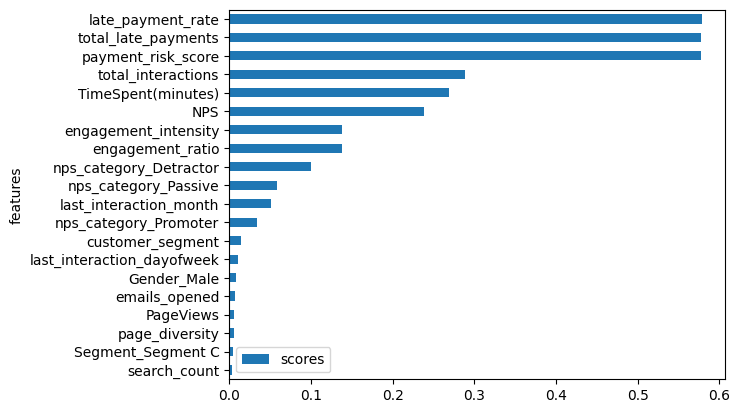

In [8]:
# plt.figure(figsize=(10, 6))

# plt.barh(mi_top_20_features['features'], mi_top_20_features['scores'])

# plt.xlabel("Mutual Information Score", fontsize=11)
# plt.title("Top 20 Features by Mutual Information", fontsize=13)

# for i, v in enumerate(mi_top_20_features['scores']):
#     plt.text(v, i, f"{v:.3f}", va='center', fontsize=9)

# plt.grid(axis='x', linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()

mi_top_20_features.iloc[::-1].plot(kind='barh', x= 'features', y='scores', legend='bottom right')

### Training a LogReg Base Model

In [9]:
X = features[mi_top_20_features['features'].to_list()]

X = X.drop(columns= ['total_late_payments', 'late_payment_rate'])

In [10]:
X.columns

Index(['payment_risk_score', 'total_interactions', 'TimeSpent(minutes)', 'NPS',
       'engagement_intensity', 'engagement_ratio', 'nps_category_Detractor',
       'nps_category_Passive', 'last_interaction_month',
       'nps_category_Promoter', 'customer_segment',
       'last_interaction_dayofweek', 'Gender_Male', 'emails_opened',
       'PageViews', 'page_diversity', 'Segment_Segment C', 'search_count'],
      dtype='object')

In [11]:
# split dataset into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# Train a Logistics Regression Model

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)

# model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not wo

In [14]:
y_pred = pipeline.predict(X_test)

# y_pred = model.predict(X_test)

In [15]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

print("MUTUAL INFO FEATURE SELECTION MODEL EVALUATION\n")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


MUTUAL INFO FEATURE SELECTION MODEL EVALUATION

Accuracy: 0.9627553063676412
Precision: 0.9787234042553191
Recall: 0.9469517022961204
F1 Score: 0.9625754527162977

Confusion Matrix:

[[1208   26]
 [  67 1196]]


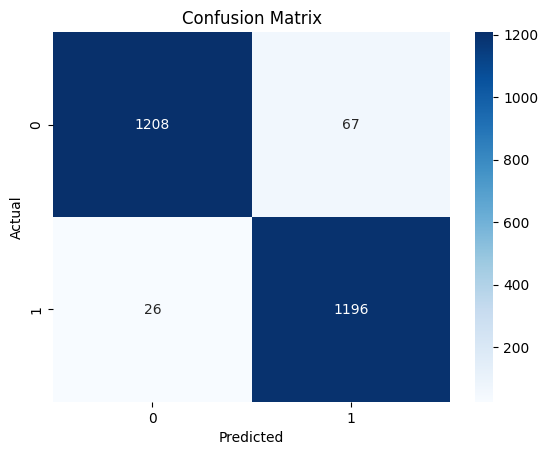

In [16]:
import seaborn as sns

cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Hyperparameter tuning for Logistic Regression

In [17]:
from sklearn.model_selection import RandomizedSearchCV
import pickle
import warnings
import json

warnings.filterwarnings('ignore')

param_dist = {
    'penalty': ['l1', 'l2', ],
    'solver': ['liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}

model = LogisticRegression(random_state=42)

random_search = RandomizedSearchCV(model, param_distributions=param_dist, cv=4, random_state=42, n_jobs=1)
random_search.fit(X_train, y_train)
print(random_search.best_params_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

with open('data.json', 'w') as file:
    json.dump(X_train.columns.to_list(), file)

print({
    'accuracy_score': accuracy_score(y_pred, y_test),
    'precision_score': precision_score(y_pred, y_test),
    'recall_score': recall_score(y_pred, y_test),
    'fi_score': f1_score(y_pred, y_test),
    'confusion_matrix': confusion_matrix(y_pred, y_test)
})



{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100}
{'accuracy_score': 0.9635562675210252, 'precision_score': 0.9493269992082344, 'recall_score': 0.9779771615008157, 'fi_score': 0.963439132181599, 'confusion_matrix': array([[1207,   64],
       [  27, 1199]])}


### HyperParameter Tuning using RandomizedSearch

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def train_and_evaluate_DT(x: pd.DataFrame, y: pd.Series) -> dict:
    """This function is used to train and evaluate a decision tree model while applying hyperparameter tuning"""

    # split the data into test and train sets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    model = DecisionTreeClassifier(random_state=42)

    param_dist = {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'splitter': ['best', 'random'],
        'max_depth': [100, 200, 300],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [0.2, 0.4, 0.6]
    }

    random_search = RandomizedSearchCV(model, param_distributions=param_dist, cv=4, random_state=42, n_jobs=1)

    random_search.fit(X_train, y_train)
    best_param = random_search.best_params_
    best_model = random_search.best_estimator_

    print(best_param)

    y_pred = best_model.predict(X_test)

    evaluation_metrics = {
        'accuracy_score': accuracy_score(y_pred, y_test),
        'precision_score': precision_score(y_pred, y_test),
        'recall_score': recall_score(y_pred, y_test),
        'fi_score': f1_score(y_pred, y_test),
        'confusion_matrix': confusion_matrix(y_pred, y_test)
    }

    return evaluation_metrics

In [76]:
train_and_evaluate_DT(X, y)

{'splitter': 'random', 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 0.6, 'max_depth': 200, 'criterion': 'log_loss'}


{'accuracy_score': 0.9651581898277933,
 'precision_score': 0.9587044534412955,
 'recall_score': 0.9704918032786886,
 'fi_score': 0.9645621181262729,
 'confusion_matrix': array([[1226,   51],
        [  36, 1184]])}